# Load musiccaps

In [9]:
from musiccaps import load_musiccaps
import numpy as np

In [2]:
ds = load_musiccaps(
    './music_data',
    sampling_rate=16000,
    limit=None,
    num_proc=8,
    writer_batch_size=1000,
)
embeddings = np.load('embeddings.npy', allow_pickle=True).item()

Using custom data configuration google--MusicCaps-7925612b943f961b
Found cached dataset csv (/home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


Loading cached processed dataset at /home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-3309f9007425eecd.arrow


Loading cached processed dataset at /home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-70279f61db8a5fbb.arrow


Loading cached processed dataset at /home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-60f7e51bf7ab1aae.arrow


Loading cached processed dataset at /home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-54cb21bf4ee59f82.arrow


Loading cached processed dataset at /home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-6cb3cbe00008b97a.arrow


Loading cached processed dataset at /home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-1a5fb4f6dff5ee60.arrow


Loading cached processed dataset at /home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-fbf6f8ab350eeb18.arrow


Loading cached processed dataset at /home/dominik/.cache/huggingface/datasets/google___csv/google--MusicCaps-7925612b943f961b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-810290b7b9443a8c.arrow


In [151]:
def create_batcher(bs):
    for epoch in itertools.count(0, 1):
        captions, embs = [], []
        
        for i in np.random.permutation(len(ds)):
            i = int(i)
            try:
                captions.append(ds[i]['caption'])
            except Exception as e:
                print(e)
                continue
            embs.append(embeddings[ds[i]['ytid']])
            
            if len(captions) == bs:
                assert len(embs) == bs
                captions = tokenizer(captions, padding='longest', return_tensors='pt')['input_ids'].cuda()
                embs = torch.from_numpy(np.stack(embs)).cuda()
                yield captions, embs, epoch
                captions, embs = [], []

# Image captioning

In [194]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torchinfo
import torch.nn as nn
from tqdm.auto import tqdm
import itertools

In [195]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").cuda()
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

encoder_forward = model.encoder.forward

In [199]:
class B2T(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(512, 768),
            nn.ReLU(),
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 768)
        )
        
    def forward(self, x):
        return self.main(x)
    
b2t = B2T().cuda()
opt = torch.optim.Adam([*b2t.parameters()], lr=0.0001) # , *model.decoder.parameters()]
losses = []
bs = 32
fake_pixel_values = torch.zeros((bs, 3, 224, 224)).cuda()
batcher = create_batcher(bs)
patch_enabled = False

In [200]:
def patched_forward(*args, **kwargs):
    result = encoder_forward(*args, **kwargs)
    if not patch_enabled:
        result.last_hidden_state = b2t(embs[0:1]).unsqueeze(1).repeat(1, 197, 1)
    else:
        result.last_hidden_state = b2t(embs).unsqueeze(1).repeat(1, 197, 1)
        # torch.randn_like(result.last_hidden_state)*0.3
    return result

model.encoder.forward = patched_forward

0it [00:00, ?it/s]

[Errno 2] No such file or directory: 'music_data/0J_2K1Gvruk.wav'
a person standing on a ledge with a bunch of stuff on it


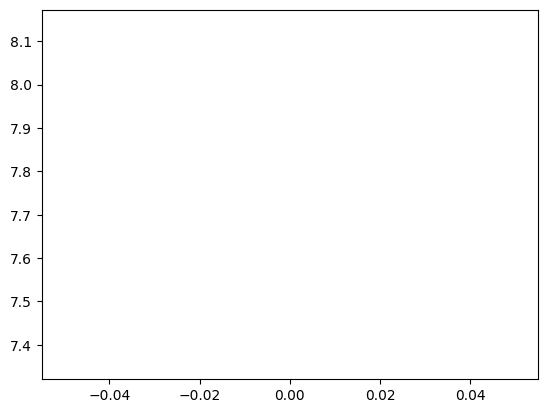

a person standing next to a wooden table with a bunch of water bottles
a person standing next to a wooden table with a bunch of water bottles


In [ ]:
for step in tqdm(itertools.count(0, 1)):
    captions, embs, epoch = next(batcher)

    patch_enabled = True
    loss = model(fake_pixel_values, labels=captions).loss
    patch_enabled = False
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    losses.append(loss.item())
    
    output_ids = model.generate(fake_pixel_values[0:1], max_length=256, num_beams=1)
    print(tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip())
    
    if step % 10 == 0:
        plt.plot(losses)
        plt.show()

In [7]:
def patched_forward(*args, **kwargs):
    for arg in args:
        if not arg is None:
            print(type(arg))
    for k, v in kwargs.items():
        if not v is None:
            print(k, type(v))
    print('---- RETURN VAL ---')
    result = f(*args, **kwargs)
    print(type(result))
    for k in result:
        print(k, getattr(result, k).shape)
    print('\n'*3)
    result.last_hidden_state[:] = torch.randn_like(result.last_hidden_state)*0.3
    return result

model.encoder.forward = patched_forward

In [156]:
f??

Signature:
f(
    pixel_values: Optional[torch.Tensor] = None,
    bool_masked_pos: Optional[torch.BoolTensor] = None,
    head_mask: Optional[torch.Tensor] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    interpolate_pos_encoding: Optional[bool] = None,
    return_dict: Optional[bool] = None,
) -> Union[Tuple, transformers.modeling_outputs.BaseModelOutputWithPooling]
Docstring:
The [`ViTModel`] forward method, overrides the `__call__` special method.

<Tip>

Although the recipe for forward pass needs to be defined within this function, one should call the [`Module`]
instance afterwards instead of this since the former takes care of running the pre and post processing steps while
the latter silently ignores them.

</Tip>

Args:
    pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
        Pixel values. Pixel values can be obtained using [`AutoImageProcessor`]. See [`ViTImageProcessor.__call

In [251]:
model.forward??

Signature:
model.forward(
    pixel_values: Optional[torch.FloatTensor] = None,
    decoder_input_ids: Optional[torch.LongTensor] = None,
    decoder_attention_mask: Optional[torch.BoolTensor] = None,
    encoder_outputs: Optional[Tuple[torch.FloatTensor]] = None,
    past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
    decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
    labels: Optional[torch.LongTensor] = None,
    use_cache: Optional[bool] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    **kwargs,
) -> Union[Tuple[torch.FloatTensor], transformers.modeling_outputs.Seq2SeqLMOutput]
Docstring:
The [`VisionEncoderDecoderModel`] forward method, overrides the `__call__` special method.

<Tip>

Although the recipe for forward pass needs to be defined within this function, one should call the [`Module`]
instance afterwards instead of this since the former takes care

In [250]:
model(pixel_values, labels=output_ids)

<class 'torch.Tensor'>
return_dict <class 'bool'>
---- RETURN VAL ---
<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
last_hidden_state torch.Size([1, 197, 768])
pooler_output torch.Size([1, 768])






Seq2SeqLMOutput(loss=tensor(2.3366, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[[ -35.8679,  -26.7638,  -27.6791,  ...,  -47.7585,  -43.8306,
           -32.5497],
         [ -42.1690,  -32.1792,  -33.5180,  ...,  -53.5255,  -48.5961,
           -37.6655],
         [ -32.6727,  -30.1231,  -34.8829,  ...,  -42.8414,  -30.4824,
           -30.9890],
         ...,
         [ -46.9919,  -44.8377,  -49.4250,  ...,  -55.7228,  -49.0115,
           -45.0781],
         [ -62.6528,  -61.6987,  -66.5732,  ...,  -79.3381,  -68.3395,
           -59.0497],
         [-125.0046, -122.8182, -127.5253,  ..., -142.7821, -135.1219,
           -94.1819]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-0.4639,  1.0217,  0.5178,  ..., -1.3494,  0.0604,  0.9517],
          [-0.8643,  0.9492,  1.7128,  ..., -1.6513, -0.4688,  1.2078],
          [-1.5492,  2.0069,  1.2288,  ..., -0.7368, -1.7374,  1.7684],
          ...,
          [-2.2556,  2.2525,  1.3288,  

In [239]:
output_ids = model.generate(pixel_values, **gen_kwargs)
tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

output_attentions <class 'bool'>
output_hidden_states <class 'bool'>
return_dict <class 'bool'>
pixel_values <class 'torch.Tensor'>
---- RETURN VAL ---
<class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
last_hidden_state torch.Size([1, 197, 768])
pooler_output torch.Size([1, 768])






'a person standing next to a pile of luggage'

In [111]:
handle.remove()
def hook(m, input, output):
    print(type(m))
    print('Input shapes', type(input), len(input))
    
    if isinstance(input, tuple):
        for x in input:
            print(type(x))
    print('Output shapes')
    
    print(type(output))
    
    
    print(output.shape)

handle = model.decoder.register_forward_hook(hook)

In [119]:

image_path = 'croissant.jpg'
image = Image.open(image_path)
if image.mode != "RGB":
    image = image.convert(mode="RGB")
pixel_values = feature_extractor(images=[image], return_tensors="pt").pixel_values.to(device)